# 6. Monte Carlo Intro
In this section we are going to be discussing another technique for solving MDP's, known as **Monte Carlo**. In the last section, you may have noticed something a bit odd; we have talked about how RL is all about learning from experience and playing games. Yet, in none of our dynamic programming algorithms did we actually play the game. We had a full model of the environment, which included all of the state transition probabilities. You may wonder: is it reasonable to assume that we would have that type of information in a real life environment? For board games, perhaps. But, what about self driving cars? 

The way that we manipulated our dynamic programming algorithms required us to put an agent into a state. That may not always be possible, especially when talking about self driving cars, or even video games. A video game starts in the state that it decides-you can't choose any state you want. This is another instance of having god mode capabilities, so it is not always realistic to assume that that is always possible. In this section, we will be playing the game and learning purely from experience. 

## 1.2 Monte Carlo Methods
Monte Carlo is a rather poorly defined term. Usually, it refers to any algorithm that involves a significantly random component. With Monte Carlo Methods in RL, the random component is the _**return**_. Recall that what we are always looking for is the expected return given that you are in state $s$. With MC, instead of calculating the true expected value of G (which requires probability distributions), we instead calculate its sample mean. 

In order for this to work, we need to assume that we are doing episodic tasks only. The reason is because an episode has to terminate before we can calculate any of the returns. This also means that MC methods are _not_ fully online algorithms. We don't do an update after every action, but rather after every episode. 

The methods that we use in the Monte Carlo section should be somewhat reminiscent of the multi armed bandit problem. With the multi armed bandit problem, we were always averaging the reward after every action. With MDP's we are always averaging the return. One way to think of Monte Carlo, is that _every state_ is a _separate multi-armed bandit problem_. What we are trying to do is learn to behave optimally for all of the multi armed bandit problems, all at once. In this section, we are again going to follow the same pattern that we did in the DP section. We will start by looking at the _**prediction problem**_ (_find the value given the policy_), and then look at the _**control problem**_ (_finding the optimal policy_). 

---

# 2.0 Monte Carlo Policy Evaluation
We are now going to solve the prediction problem using Monte Carlo Estimation. Recall that the definition of the value function is that it is the expected value of the future return, given that the current state is $s$:

$$V_\pi(s) = E \big[G(t) \mid S_t = s\big]$$

We know that we can estimate any expected value simply by adding up samples and dividing by the total number of samples:

$$\bar{V}_\pi(s) = \frac{1}{N} \sum_{i =1}^N G_{i,s}$$

Where above, $i$ is indexing the episode, and $s$ is indexing the state. The question now, is how do we get these sample returns. 

## 2.1 How do we generate $G$?
In order to get these sample returns, we need to play many episodes to generate them! For every episode that we play, we will have a sequence of states and rewards. And from the rewards, we can calculate the returns by definition, which is just the sum of all future rewards:

$$G(t) = r(t+1) + \gamma * G(t+1)$$

Notice how, to actually implement this in code, it would be very useful to loop through the states in reverse order, since $G$ depends only on future values. Once we have done this for many episodes, we will have multiple lists of $s$'s and $G$'s. We can then take the sample mean. 

## 2.2 Mutliple Visits to $s$
One interesting question that comes up is, what if you see the same state more than once in an episode? For instance if you see state $s$ at $t=1$ and $t=3$? What is the return for state $s$? Should we use $G(1)$ or $G(3)$? There are two answers to this question, and surprisingly they both lead to the same answer. 

**First Visit Monte Carlo**<br>
The first method is called _first visit monte carlo_. That means that you would only count the return for time $t=1$. 

**Every Visit Monte Carlo**<br>
The second method is called _every visit monte carlo_. That means that you would calculate the return for every time you visited the state $s$, and all of them would contribute to the sample mean; i.e. use both $t=1$ and $t=3$ as samples. 

Surprisingly, it has been proven that both lead to the same answer. 

## 2.3 First-Visit MC Pseudocode
Let's now look at some pseudocode for first visit monte carlo prediction. 

```
def first_visit_monte_carlo_prediction(pi, N):
  V = random initialization
  all returns = {} # default = []
  do N times:
    states, returns = play_episode
    for s, g in zip(states, returns):
      if not seen s in this episode yet:
        all_returns[s].append(g)
        V(s) = sample_mean(all_returns[s])
  return V
```

In the above pseudocode we can see the following:
> * The input is a policy, and the number of samples we want to generate
* We initialize $V$ randomly, and we create a dictionary to store our returns, with a default value being an empty list
* We loop N times. Inside the loop we generate an episode by playing the game. 
* Next, we loop through the state sequence and return sequence. We only include the return if this the first time we have seen this state in this episode since this is first visit MC.
* If so, we add this return to our list of returns for this state. 
* Next, we update V(s) to be the sample mean of all the returns we have collected for this state. 
* At the end, we return $V$. 

## 2.4 Sample Mean
One thing that you may have noticed for the pseudocode, is that it requires us to store all of the returns that we get for each state so that the sample mean can be calculated. But, if you recall from our section on the multi armed bandit, there are more efficient ways to calculate the mean, such as calculating it from the previous mean. There are also techniques for nonstationary problems, like using a moving average. So, all of the techniques we have learned already still apply here. 

Another thing that we should notice about the MCM, is that because we are calculating the sample mean, all of the same rules of probability apply. That means that the confidence interval is approximately Gaussian, and the variance if the original variance of the data, divided by the number of samples collected:

$$\text{Variance of Estimate} = \frac{\text{variance of RV}}{N}$$

Therefore, we are going to more confident in data that has more samples, but it grows slowly with respect to the number of samples. 

## 2.5 Calculating Returns from Rewards
For full clarity, we will also quickly go over how to calculate the returns from the rewards in pseudocode. 

```
# Calculating State and Reward Sequences 
s = grid.current_state()
states_and_rewards = [(s, 0)]
while not game_over:
  a = policy(s)
  r = grid.move(a)
  s = grid.current_state()
  states_and_rewards.append((s, r))
  
# Calculating the Returns
G = 0 
states_and_returns = []
for s, r in reverse(states_and_rewards):
  states_and_returns.append((s, G))
  G = r + gamma*G
states_and_returns.reverse()
```

The above pseudocode shows two main steps:
1. Calculating State and Reward Sequences. This is just playing the game, and keeping a log of all the states and rewards that we get, in the order we get them. Notice, this is a list of tuples. Also, first award is assumed to be 0. We do not get any reward simply for arriving at the start state. 
2. Calculating the Returns. We start with empty list, and then loop through the states and rewards in reverse order. In the first order of this loop, the state s represents the terminal state and G will be 0. Next we update G. Notice how, on the first iteration of the loop, this includes the reward for the terminal state. Once the loop is done, we reverse the list of states and returns, since we want it to be in the order that we visited the states. 

## 2.6 Note on MC
One final thing to note about MC. Recall that one of the disadvantages of DP is that we have to loop through the entire set of states on every iteration, and that this is bad for most practical scenarios in which there are a large number of states. Notice how MC only updates the value for states that we actually visit. That means even if the state space is large, if we only ever visit a small subset of states, then it doesn't matter. 

Also notice, we don't even need to know what the states are! We can simply discover them by playing the game. So, there are some advantages to MC in situations where doing full exact calculations is infeasible. 

---

# 3.0 Monte Carlo Policy Evaluation in Code
We are now going to implement Monte Carlo for finding the State-Value function in code. 


In [1]:
import numpy as np
from common import standard_grid, negative_grid, print_policy, print_values

SMALL_ENOUGH = 10e-4
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

# NOTE: This is only policy evaluation, NOT optimization

def play_game(grid, policy):
  """Returns a list of states and corresponding returns"""
  
  # Reset game to start at a random position. We need to do this, because given our 
  # current deterministic policy (we take upper left path all the way to goal state, and 
  # for any state not in that path, to go all the way to losing state. Since MC only 
  # calculates values for states that are actually visited, and if we only started at the
  # prescribed start state, there will be some states that we never visit. So we need this 
  # little hack at the beginning of play game, that allows us to start the game at any 
  # state. This is called the exploring starts method. 
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])
  
  # Play the game -> goal is to make a list of all states we have visited, and all rewards
  # we have received
  s = grid.current_state()
  states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
  while not grid.game_over():
    a = policy[s] 
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s, r))
    
  # Calculate the returns by working backward from the terminal state. We visit each state
  # in reverse, and recursively calculate the return. 
  G = 0 
  states_and_returns = []
  first = True
  for s, r in reversed(states_and_rewards): 
    # The value of the terminal state is 0 by definition. We should ignore the first state 
    # we encounter, and ignore the last G, which is meaningless since it doesn't 
    # correspond to any move. 
    if first:
      first = False
    else:
      states_and_returns.append((s, G))
    G = r + GAMMA * G
  states_and_returns.reverse() # we want it in the order of state visited
  return states_and_returns
      
if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
  }
  
  # Initialize V(s) and returns
  V = {}
  returns = {}
  states = grid.all_states()
  for s in states:
    if s in grid.actions:
      returns[s] = []
    else:
      # terminal state or state we can't get to otherwise
      V[s] = 0 
      
  # ------ Monte Carlo Loop ------
  # Plays the games and gets the states and returns list. 
  for t in range(100):
    # Generate an episode using pi. Create set to keep track of all the states that we 
    # have seen, since we only want to add a return if it is the first time we have seen
    # the state in this episode. 
    states_and_returns = play_game(grid, policy)
    seen_states = set()
    
    # Loop through all states and returns.
    for s, G in states_and_returns:
      # Check if we have already seen s, called "first-visit: MC policy evaluation
      if s not in seen_states:
        returns[s].append(G)
        V[s] = np.mean(returns[s]) # Recalculate V(s) because we have new sample return
        seen_states.add(s)

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
values:
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00|-1.00| 0.00|
---------------------------
 0.66|-0.81|-0.90|-1.00|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


---

# 4.0 Policy Evaluation in Windy Grid World
We are now going to use MC predicton algorithm to find $V$, but this time we will be in windy gridworld and will be using a slightly different policy. One thing that you may have noticed with the last script is that MC wasn't really needed since the returns were deterministic. This was because the two probability distributions that we are interested in- $\pi(a \mid s)$ and $p(s,a \mid s',r)$- were both _deterministic_.

In windy gridworld the state transitions are not deterministic, so we will have a source of randomness, and hence a need for MC. Also, the policy will be different. In particular, this policy is always going to try and win; in other words, travel to the goal state. We will see that even though this policy is to go to the goal state, not all values will end up positive, since in windy gridworld the wind can still end up pushing you into the losing state. So on average, the return for that state is negative. 

In [2]:
import numpy as np
from common import standard_grid, negative_grid, print_policy, print_values

SMALL_ENOUGH = 10e-4
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

def random_action(a):
  # 0.5 probability of performing chosen action
  # 0.5/3 probability of doing some action a' != a
  p = np.random.random()
  if p < 0.5:
    return a
  else:
    tmp = list(ALL_POSSIBLE_ACTIONS)
    tmp.remove(a)
    return np.random.choice(tmp)
  
def play_game(grid, policy):
  """Returns a list of states and corresponding returns"""
  
  # Reset game to start at a random position. We need to do this, because given our 
  # current deterministic policy (we take upper left path all the way to goal state, and 
  # for any state not in that path, to go all the way to losing state. Since MC only 
  # calculates values for states that are actually visited, and if we only started at the
  # prescribed start state, there will be some states that we never visit. So we need this 
  # little hack at the beginning of play game, that allows us to start the game at any 
  # state. This is called the exploring starts method. 
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])
  
  # Play the game -> goal is to make a list of all states we have visited, and all rewards
  # we have received
  s = grid.current_state()
  states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
  while not grid.game_over():
    a = policy[s] 
    a = random_action(a) # ----- THIS IS THE UPDATE FOR WINDY GRIDWORLD -----
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s, r))
    
  # Calculate the returns by working backward from the terminal state. We visit each state
  # in reverse, and recursively calculate the return. 
  G = 0 
  states_and_returns = []
  first = True
  for s, r in reversed(states_and_rewards): 
    # The value of the terminal state is 0 by definition. We should ignore the first state 
    # we encounter, and ignore the last G, which is meaningless since it doesn't 
    # correspond to any move. 
    if first:
      first = False
    else:
      states_and_returns.append((s, G))
    G = r + GAMMA * G
  states_and_returns.reverse() # we want it in the order of state visited
  return states_and_returns

if __name__ == '__main__':
  grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)
  
  # state -> action
  # found by policy_iteration_random on standard_grid
  # MC method won't get exactly this, but should be close
  # values:
  # ---------------------------
  #  0.43|  0.56|  0.72|  0.00|
  # ---------------------------
  #  0.33|  0.00|  0.21|  0.00|
  # ---------------------------
  #  0.25|  0.18|  0.11| -0.17|
  # policy:
  # ---------------------------
  #   R  |   R  |   R  |      |
  # ---------------------------
  #   U  |      |   U  |      |
  # ---------------------------
  #   U  |   L  |   U  |   L  |
  # ----- This policy has changed from the previous example! -----
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'U',
    (2, 1): 'L',
    (2, 2): 'U',
    (2, 3): 'L',
  }
  
  # Everything else from here down is the same. The Monte Carlo algorithm doesn't change
  # becasue the fact that we are taking averages already takes into account any 
  # randomness both in the policy and in the state transitions. 
  
  # initialize V(s) and returns
  V = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions:
      returns[s] = []
    else:
      # terminal state or state we can't otherwise get to
      V[s] = 0
      
  # repeat until convergence
  for t in range(5000):

    # generate an episode using pi
    states_and_returns = play_game(grid, policy)
    seen_states = set()
    for s, G in states_and_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      if s not in seen_states:
        returns[s].append(G)
        V[s] = np.mean(returns[s])
        seen_states.add(s)

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
values:
---------------------------
 0.42| 0.55| 0.72| 0.00|
---------------------------
 0.32| 0.00| 0.20| 0.00|
---------------------------
 0.25| 0.18| 0.09|-0.17|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  L  |  U  |  L  |


---

# 5.0 Monte Carlo Control
If you recall, the pattern that we are generally trying to follow is:

> First look at how to solve the _prediction problem_, which finding the value function given a policy. We then want to look at how to solve the _control problem_, which is how to find the optimal policy. 

We are now going to go about finding the optimal policy using MC. 

## 5.1 MC for Control Problem
When we first try and do this, you will see that we come across a big problem. That is, we only have $V(s)$ for a given policy, but we don't know what actions will lead to a better $V(s)$ because we can't do a look ahead search. With MC, all we are able to do is play an episode straight through and use the returns as samples. The key to using MC for the control problem then, is to find $Q(s,a)$, since $Q$ is indexed by both $s$ and $a$, and we can choose the argmax over $a$ to find the best policy:

$$argmax_a\big( Q(s,a)\big)$$

## 5.2 MC for $Q(s,a)$
So, how exactly do we use MC to find $Q$? The process is nearly the same as we used to find $V$, except that instead of just returning tuples of states and returns, (s, G), we will return triples of states, actions, and returns, (s, a, G). 

We can quickly see how this may be problematic. Recall that the number of values we need to store grows quadratically with the state set size and action set size. With $V(s)$ we only need $\mid S \mid$ different estimates. With $Q(s,a)$ we need $\mid S \mid * \mid A \mid$ different estimates. That means that we have a lot more values to approximate, and we need to do many more steps of MC in order to get a good answer. 

There is another problem with trying to estimate $Q$, which goes back to our explore/exploit dilemma. If we have a fixed policy, then every $Q(s,a)$ will only have samples for _one_ action. That means, out of the total $\mid S \mid * \mid A \mid$ values we need to fill in, we will only be able to fill in $\frac{1}{\mid A \mid}$ of those values. 

The way to fix this, as we discussed earlier, is using the exploring starts method. In this case, we now randomly choose an initial state and an initial action. Thereafter we follow the policy. So, the answer that we get is $Q_\pi(s,a)$. This is consistent with our defintion of $Q$:

$$Q_\pi(s,a) = E_\pi \big[G(t) \mid S_t = s, A_t=a\big]$$

## 5.3 Back to Control Problem
Let's now return to the control problem. If you think carefully, you'll realize that we already know the answer to this problem. We discussed earlier how the method that we always used to find an optimal policy is generalized policy iteration, where we alternate between policy evaluation and policy improvement. For policy evaulation, we just discussed it-we will simply use MC to get an estimate for $Q$. The policy improvement step is the same as always, we just take the argmax over the actions from $Q$:

$$\pi(s) = argmax_a Q(s,a)$$

## 5.4 Problem with MC
One issue with this as we have already discussed, is that because we need to find $Q$ over all states and all actions, this can take a very long time using sampling. We again have a problem where there is an iterative algorithm inside an iterative algorithm. 

The solution to this is to take the same approach that we do with value iteration. Instead of doing a fresh MC policy evaluation on each round, where it would take a long time to collect samples, we instead update the same $Q$ and do policy improvement after every single episode. This means that on every iteration of the outer loop we generate only one episode, use that episode to improve our estimate of $Q$, and then immediately do the policy improvement step. 

## 5.5 Pseudocode
We can now look at this in pseudocode to solidify this idea:

```
Q = random, pi = random

while True: 
  s, a = randomly select from S and A     # Exploring starts method
  
  # Generate an episode from this starting position, following current policy
  # Receive a list of triply containing states, actions, and returns
  states_actions_returns = play_game(start=(s,a))
  
  # Policy Evaluation Step
  for s,a,G in states_actions_returns:
    returns(s,a).append(G)
    
    # Recalculate Q as average of all returns for this state action pair
    Q(s,a) = average(returns(s,a)) 
    
  # Policy improvement step
  for s in states:
    pi(s) = argmax[a] { Q(s,a) }
```

# 5.6 One more problem
There is one more subtle problem with this algorithm; Recall that if we take an action that results in us bumping into a wall, we end up in the same state as before. So, if we follow this policy we will never end up in a terminal state and therefore never finish the episode. To avoid this problem, we can introduce a hack: if we end up in the same state after doing an action, this will give us a reward of -100 and end the episode. 

## 5.7 MC 
It is interesting that this method converges, even though the returns that we average for $Q$ are for different policies. Intuitively, $Q$ has to converge, since if it is suboptimal, then the policy will change, and that will in turn cause $Q$ to change. We can only achieve stability when both the value and policy to converge to the optimal value and optimal policy. Interestingly, this have never been formally proven. 

---

# 6. Monte Carlo Control in Code
We are now going to use Monte Carlo exploring starts to solve the control problem, aka find the optimal policy and the optimal value function. 

rewards:
---------------------------
-0.90|-0.90|-0.90| 1.00|
---------------------------
-0.90| 0.00|-0.90|-1.00|
---------------------------
-0.90|-0.90|-0.90|-0.90|
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


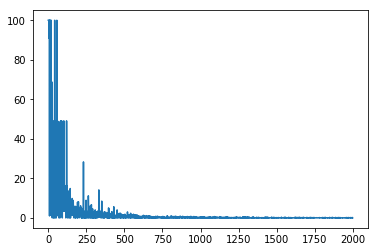

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  L  |  U  |  U  |
final values:
---------------------------
-0.90| 0.00| 1.00| 0.00|
---------------------------
-1.83| 0.00|-1.00| 0.00|
---------------------------
-3.81|-5.56|-2.18|-1.00|


In [5]:
import matplotlib.pyplot as plt

GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

def play_game(grid, policy):
  # Reset game to start at a random position. We need to do this, because given our 
  # current deterministic policy (we take upper left path all the way to goal state, and 
  # for any state not in that path, to go all the way to losing state. Since MC only 
  # calculates values for states that are actually visited, and if we only started at the
  # prescribed start state, there will be some states that we never visit. So we need this 
  # little hack at the beginning of play game, that allows us to start the game at any 
  # state. This is called the exploring starts method. 
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])
  
  s = grid.current_state()
  a = np.random.choice(ALL_POSSIBLE_ACTIONS) # first action is uniformly random
  
  
  # Be aware of the timing. Each triple is s(t), a(t), r(t) but r(t) results 
  # from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  seen_states = set()
  while True:
    old_s = grid.current_state()
    r = grid.move(a)
    s = grid.current_state()
    
    if s in seen_states:
      # Hack so that we don't end up in infinitely long episode, bumping into wall
      states_actions_rewards.append((s, None, -100))
      break
    elif grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else: 
      a = policy[s]
      states_actions_rewards.append((s, a, r))
    seen_states.add(s)
    
  # calculate the returns by working backwards from the terminal state, 
  # NOW ADDING IN ACTIONS
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + GAMMA*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns


# Function to do max and argmax from a dictionary (what we are using to store Q)
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val
  
if __name__ == '__main__':
  # Try the negative grid too, to see if agent will learn to go past the "bad spot"
  # in order to minimize number of steps
  grid = negative_grid(step_cost=-0.9)
  
  # Print rewards
  print("rewards:")
  print_values(grid.rewards, grid)
  
  # state -> action
  # initialize a random policy
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

  # initialize Q(s,a) and returns
  Q = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions: # not a terminal state
      Q[s] = {}
      for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0 # needs to be initialized to something so we can argmax it
        returns[(s,a)] = []
    else:
      # terminal state or state we can't otherwise get to
      pass
    
  # Main Loop - repeat until convergence
  deltas = [] # For debugging purposes 
  for t in range(2000):
    if t % 100 == 0:
      print(t)

    # Generate an episode using pi. Play a game, get states, actions, and returns triples
    biggest_change = 0
    states_actions_returns = play_game(grid, policy)
    seen_state_action_pairs = set() # Create set to store state-actions pairs we have seen
    
    # Loop through all state action pairs in episode, update their returns list, and 
    # update Q
    for s, a, G in states_actions_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      sa = (s, a)
      if sa not in seen_state_action_pairs:
        old_q = Q[s][a]
        returns[sa].append(G)
        Q[s][a] = np.mean(returns[sa])
        biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
        seen_state_action_pairs.add(sa)
    deltas.append(biggest_change)

    # ---- Policy Improvement Step ---- update policy 
    for s in policy.keys():
      policy[s] = max_dict(Q[s])[0]

  plt.plot(deltas)
  plt.show()

  print("final policy:")
  print_policy(policy, grid)

  # find V
  V = {}
  for s, Qs in Q.items():
    V[s] = max_dict(Q[s])[1]

  print("final values:")
  print_values(V, grid)

---

# 7. Monte Carlo Control _without_ Exploring Starts
Recall that one of the disadvantages of the method we just looked at, is that we need to use exploring starts. We talked about how that may be infeasible for any game we are not playing in "God-mode". For example, think of a self driving car; it wouldn't be possible to enumerate all of the possible edge cases that the car may find itself in. And even if you could, it would take a lot of work to put the car in those exact states. So, we will now look at how we could use MC for control, _without_ using exploring starts. 

Earlier, we briefly touched upon the fact that all techniques we learning for the multi armed bandit problem are applicable here. In particular, we don't want to follow the _greedy_ policy, but the _espilon-greedy_ policy instead (or any other method that allows for more exploration). 

The modifications to the code should be fairly simple. All we need to do is remove exploring starts (always start at official starting position), and change the policy to sometimes be random (in portion where we play the game, instead of just following the greedy policy, we will have a small probability $\epsilon$ of doing a random action). 

## 7.2 Epsilon-Soft
Note, in some sources you will see an algorithm called epsilon-soft. This looks a little bit different, but essentially does the same thing. The idea is that epsilon is used to ensure that every action has the possibility of being selected. We state this as:

> The probability of $a$ given $s$ is greater than or equal to $\epsilon$ divided by the number of possible actions. 

$$\pi(a \mid s) \geq \frac{\epsilon}{\mid A(s)\mid} , \forall a \in A(s)$$

But, we also use epsilon to decide whether or not we are going to explore. So, we can write this in total as:

$$a^* = argmax_aQ(s,a)$$
$$\pi(s \mid a) = 1 - \epsilon + \frac{\epsilon}{\mid A(s)\mid} \; if \; a = a^*$$
$$\pi(s \mid a) = \frac{\epsilon}{\mid A(s)\mid} \; if \; a \neq a^*$$

From now on we will just refer to this as epsilon greedy. 

## 7.3 How often will we reach off-policy states?
It is interesting to think about how often we will reach off-policy states. For a state that is $K$ steps away from the start state, we would need to be in exploration mode on each step, and chose the necessary states to get to the target state. So in total, that is:

$$p \geq \Big(\frac{\epsilon}{\mid A(s)\mid}\Big)^K$$ 

You can imagine that this is a very small number, so for states that are very far off from the policies trajectory, you will need to do many iterations of MC for the value to be accurate for those states. 

---

#  8. MC Control _without_ Exploring Starts in code

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
0
1000
2000
3000
4000


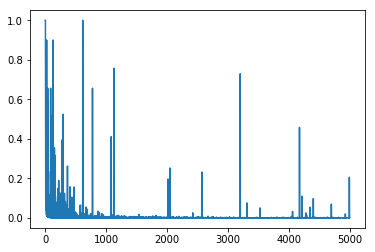

final values:
---------------------------
 0.58| 0.77| 1.00| 0.00|
---------------------------
 0.41| 0.00| 0.77| 0.00|
---------------------------
 0.25| 0.39| 0.56| 0.46|
final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


In [6]:
def random_action(a, eps=0.1):
  # choose given a with probability 1 - eps + eps/4
  # choose some other a' != a with probability eps/4
  p = np.random.random()
  # if p < (1 - eps + eps/len(ALL_POSSIBLE_ACTIONS)):
  #   return a
  # else:
  #   tmp = list(ALL_POSSIBLE_ACTIONS)
  #   tmp.remove(a)
  #   return np.random.choice(tmp)
  #
  # this is equivalent to the above
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)
  
def play_game(grid, policy):
  # returns a list of states and corresponding returns
  # in this version we will NOT use "exploring starts" method
  # instead we will explore using an epsilon-soft policy
  s = (2, 0)
  grid.set_state(s)
  a = random_action(policy[s])

  # be aware of the timing
  # each triple is s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  while True:
    r = grid.move(a)
    s = grid.current_state()
    if grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else:
      # HERE WE HAVE ADDED EPSILON GREEDY POLICY
      a = random_action(policy[s]) # the next state is stochastic
      states_actions_rewards.append((s, a, r))

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + GAMMA*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns

if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  # grid = standard_grid()
  # try the negative grid too, to see if agent will learn to go past the "bad spot"
  # in order to minimize number of steps
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # initialize a random policy
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

  # initialize Q(s,a) and returns
  Q = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions: # not a terminal state
      Q[s] = {}
      for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0
        returns[(s,a)] = []
    else:
      # terminal state or state we can't otherwise get to
      pass

  # repeat until convergence
  deltas = []
  for t in range(5000):
    if t % 1000 == 0:
      print(t)

    # generate an episode using pi
    biggest_change = 0
    states_actions_returns = play_game(grid, policy)

    # calculate Q(s,a)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      sa = (s, a)
      if sa not in seen_state_action_pairs:
        old_q = Q[s][a]
        returns[sa].append(G)
        Q[s][a] = np.mean(returns[sa])
        biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
        seen_state_action_pairs.add(sa)
    deltas.append(biggest_change)

    # calculate new policy pi(s) = argmax[a]{ Q(s,a) }
    for s in policy.keys():
      a, _ = max_dict(Q[s])
      policy[s] = a

  plt.plot(deltas)
  plt.show()

  # find the optimal state-value function
  # V(s) = max[a]{ Q(s,a) }
  V = {}
  for s in policy.keys():
    V[s] = max_dict(Q[s])[1]

  print("final values:")
  print_values(V, grid)
  print("final policy:")
  print_policy(policy, grid)

---

# 9. Summary
Let's take a brief moment to summarize everything we have learned about in this section. This section was all about MC methods. In the last section on Dynamic programming, we made a rather weird assumption that we _knew_ all of the state transition probabilities and never actually played the game. Hence, we were never able to learn from experience, as you would expect a reinforcement learning agent to do. 

We followed our usual pattern of first looking at the prediction problem and then looking a the control problem. The main technique that we used with Monte Carlo is that the Value function is the expected return given a state:

$$V_\pi(s) = \Big[G(t) \mid S_t=s\Big]$$

We know from probability theory that the expected value of something can be approximated by its sample mean:

$$\bar{V}_\pi(s) = \frac{1}{N} \sum_{i=1}^N G_{i,s}$$

In order to use Monte Carlo, we needed to generate episodes, and calculate the returns for each episode. This gave a list of pairs of states and returns. We then average these returns to find the value for each state. 

Recall, there are two methods for average the returns: **first visit** and **every visit**. While these have both been proven to converge to the same result, we use first visit because it is simpler. 

## 9.1 MC vs. DP
We saw that MC can be more efficient than DP because we don't need to loop through the entire state space. Because of this, we may never get the full value function, however it may not matter if many of those states may never be reached, or only be reached very rarely. In other words, the more we visit a state, the more accurate the value will be for that state. Since the MC method results in each state being visited a different number of times depending on the policy, we used the exploring starts technique in order to make sure we had adequate data for each state. 

## 9.2 MC Control
We then looked at the control problem. The difference with MC is that we now need to use $Q$ instead of $V$, so that we can take the argmax of $Q$ over all of the actions. This is required since we can't do the same kind of look ahead search with MC, as we did with DP. We then saw that we can continue to use the idea of policy iteration that we had used in the DP section. Recall, this is where we alternate between policy evaluation and policy improvement. We talked about the fact that MC has one major disadvantage here: it needs many samples in order to be accurate, and it has to be inside of a loop, which makes it very inefficient. We ended up taking the same approach here as we did with value iteration; we only did one update for evaluation per iteration. What is surprising is that it converges even though the samples are not all for the same policy! Note, it never has been formally proven to converge. 

One of the disadvantages of the control solution we looked at was that we needed to use the exploring starts method in order to get a full measurement of $Q$. We saw that it is not necessary to use exploring starts, if we use epsilon greedy instead. This is because epsilon greedy allows us to continually explore all of the states in the state space. We learned that all of the techniques we learned about in the multi armed bandit still apply here. In fact, MDPs are like having different multi armed bandit problems at each state. 